# HR ATTRIBUTION

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree  
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

# 1.) Import, split data into X/y, plot y data as bar charts, turn X categorical variables binary and tts.

In [2]:
df = pd.read_csv("HR_Analytics.csv")

In [3]:
y = df[["Attrition"]].copy()
X = df.drop("Attrition", axis = 1)

In [4]:
y["Attrition"] = [1 if i == "Yes" else 0 for i in y["Attrition"]]

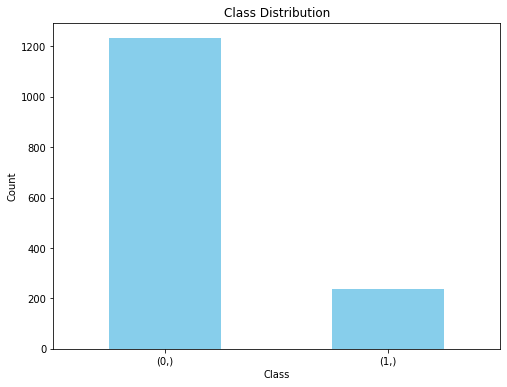

In [5]:
class_counts = y.value_counts()


plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=0)  # Remove rotation of x-axis labels
plt.show()



In [6]:
# Step 1: Identify string columns
string_columns = X.columns[X.dtypes == 'object']

# Step 2: Convert string columns to categorical
for col in string_columns:
    X[col] = pd.Categorical(X[col])

# Step 3: Create dummy columns
X = pd.get_dummies(X, columns=string_columns, prefix=string_columns,drop_first=True)




In [7]:
x_train,x_test,y_train,y_test=train_test_split(X,
 y, test_size=0.20, random_state=42)


# 2.) Using the default Decision Tree. What is the IN/Out of Sample accuracy?

In [8]:
clf = DecisionTreeClassifier()
clf.fit(x_train,y_train)
y_pred=clf.predict(x_train)
acc=accuracy_score(y_train,y_pred)
print("IN SAMPLE ACCURACY : " , round(acc,2))

y_pred=clf.predict(x_test)
acc=accuracy_score(y_test,y_pred)
print("OUT OF SAMPLE ACCURACY : " , round(acc,2))

IN SAMPLE ACCURACY :  1.0
OUT OF SAMPLE ACCURACY :  0.77


# 3.) Run a grid search cross validation using F1 score to find the best metrics. What is the In and Out of Sample now?

In [9]:

# Define the hyperparameter grid to search through
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 11),  # Range of max_depth values to try
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


dt_classifier = DecisionTreeClassifier(random_state=42)

scoring = make_scorer(f1_score, average='weighted')

grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring, cv=5)

grid_search.fit(x_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best F1-Score:", best_score)


Best Parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best F1-Score: 0.8214764475510983


In [10]:
clf = tree.DecisionTreeClassifier(**best_params, random_state =42)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_train)
acc=accuracy_score(y_train,y_pred)
print("IN SAMPLE ACCURACY : " , round(acc,2))

y_pred=clf.predict(x_test)
acc=accuracy_score(y_test,y_pred)
print("OUT OF SAMPLE ACCURACY : " , round(acc,2))

IN SAMPLE ACCURACY :  0.91
OUT OF SAMPLE ACCURACY :  0.83


# 4.) Plot ......

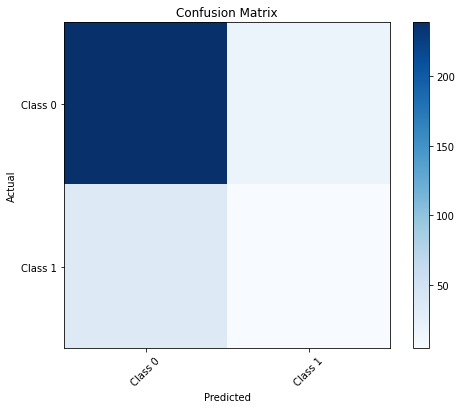

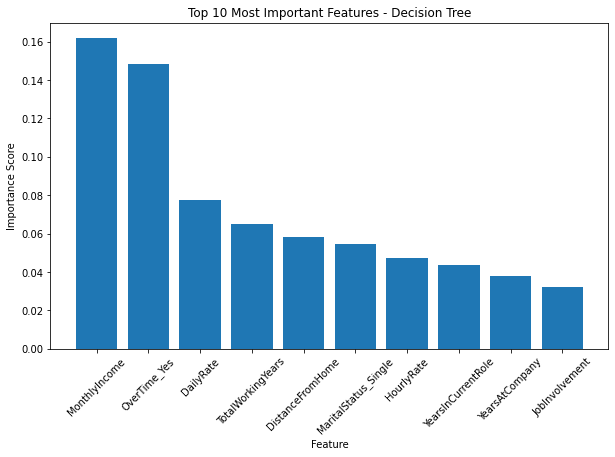

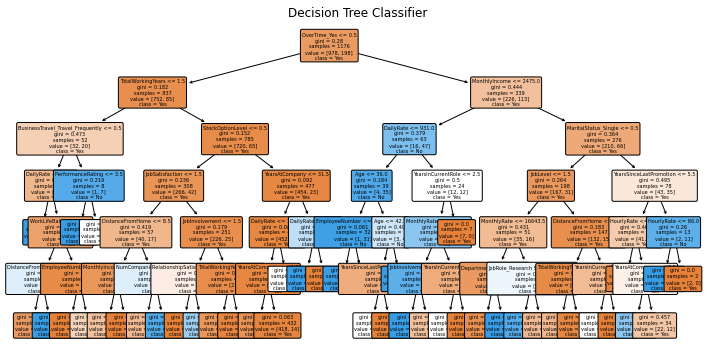

In [11]:
# Make predictions on the test data
y_pred = clf.predict(x_test)
y_prob = clf.predict_proba(x_test)[:, 1]

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(conf_matrix))
plt.xticks(tick_marks, ['Class 0', 'Class 1'], rotation=45)
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




feature_importance = clf.feature_importances_

# Sort features by importance and select the top 10
top_n = 10
top_feature_indices = np.argsort(feature_importance)[::-1][:top_n]
top_feature_names = X.columns[top_feature_indices]
top_feature_importance = feature_importance[top_feature_indices]

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
plt.bar(top_feature_names, top_feature_importance)
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Top 10 Most Important Features - Decision Tree')
plt.xticks(rotation=45)
plt.show()

# Plot the Decision Tree for better visualization of the selected features
plt.figure(figsize=(12, 6))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=["Yes", "No"], rounded=True, fontsize=5)
plt.title('Decision Tree Classifier')
plt.show()



# 5.) Looking at the graphs. what would be your suggestions to try to improve employee retention? What additional information would you need for a better plan. Plot anything you think would assist in your assessment.

## ANSWER :

In [12]:
from scipy.stats import pearsonr

In [32]:
np.corrcoef(np.array(X["OverTime_Yes"]),np.array(y["Attrition"]))

array([[1.        , 0.24611799],
       [0.24611799, 1.        ]])

# 6.) Using the Training Data, if they made everyone work overtime. What would have been the expected difference in client retention?

In [15]:
x_train_experiment = x_train.copy()

In [16]:
x_train_experiment["OverTime_Yes"] = 0.

In [17]:
y_pred = clf.predict(x_train)
y_pred_experiment = clf.predict(x_train_experiment)

In [18]:
diff = sum(y_pred - y_pred_experiment)
print(diff)

59


# 7.) If they company loses an employee, there is a cost to train a new employee for a role ~2.8 * their monthly income.
# To make someone not work overtime costs the company 2K per person.
# Is it profitable for the company to remove overtime? If so/not by how much? 
# What do you suggest to maximize company profits?

In [19]:
x_train_experiment["Y"] = y_pred
x_train_experiment["Y_exp"] = y_pred_experiment

In [20]:
x_train_experiment["RetChange"] = x_train_experiment["Y_exp"] - x_train_experiment["Y"]

In [24]:
sav = sum(-2.8 * x_train_experiment["RetChange"]* x_train_experiment["MonthlyIncome"])

In [25]:
cost = len(x_train[x_train["OverTime_Yes"]]==1)*2000

In [26]:
sav - cost

-117593.99999999977

## ANSWER : 

# 8.) Use your model and get the expected change in retention for raising and lowering peoples income. Plot the outcome of the experiment. Comment on the outcome of the experiment and your suggestions to maximize profit.

In [28]:
raise_amount = 100

In [30]:
profits = []
for raise_amount in range (-1000, 1000, 100): 
    
    x_train_experiment = x_train.copy()
    x_train_experiment["MonthlyIncome"]= x_train_experiment["MonthlyIncome"] + raise_amount
    
    y_pred = clf.predict(x_train)
    y_pred_experiment = clf.predict(x_train_experiment)
    
    diff = sum(y_pred - y_pred_experiment)
    print("Change in attrition", diff)
    
    x_train_experiment["Y"] = y_pred
    x_train_experiment["Y_exp"] = y_pred_experiment
    
    x_train_experiment["Retchange"]= x_train_experiment["Y_exp"] - x_train_experiment["Y"]
    
    sav = sum(-2.8 * x_train_experiment["Retchange"] * x_train_experiment['MonthlyIncome'])
    
    cost = len(x_train)*raise_amount
    
    print("Profit, ", sav-cost)
    profits.append(sav-cost)

Change in attrition -16
Profit,  1087584.4
Change in attrition -14
Profit,  979524.0
Change in attrition -13
Profit,  864992.8
Change in attrition -12
Profit,  750738.8
Change in attrition -12
Profit,  629778.8
Change in attrition -9
Profit,  530138.0
Change in attrition -7
Profit,  424200.0
Change in attrition -4
Profit,  326096.4
Change in attrition -1
Profit,  228440.8
Change in attrition -1
Profit,  110714.8
Change in attrition 0
Profit,  0.0
Change in attrition 6
Profit,  -75328.40000000001
Change in attrition 15
Profit,  -127503.60000000002
Change in attrition 15
Profit,  -240914.8
Change in attrition 21
Profit,  -311586.80000000005
Change in attrition 22
Profit,  -416449.6000000001
Change in attrition 22
Profit,  -527889.6000000001
Change in attrition 22
Profit,  -639329.6000000001
Change in attrition 22
Profit,  -750769.6000000001
Change in attrition 23
Profit,  -854999.6000000001


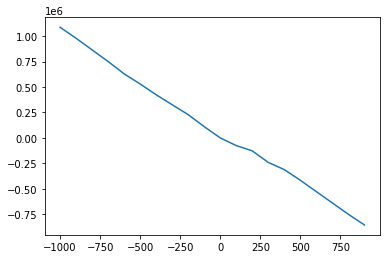

In [31]:
plt.plot(range(-1000,1000,100), profits)
plt.show()

## ANSWER : 

#### To maximize profit, the company should not raise salary to prevent employees from leaving the company 